In [83]:
import glob
import xarray as xr
import numpy as np


#Functions

def get_global_weights():
    
     #Get the latitude weights from a special location
    r1 = '/network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/speedyone/paper/Fig1_10year_Williams/'
    f = r1 + 'speedyoneWILLIAMS_L2_52_RN_10y/model_output00001.nc'
    df = xr.open_dataset(f)
    
    temp_file = df.temperature
    weights = np.cos(np.deg2rad(temp_file.latitude))
         
    weights.name = "weights"
    
    
    return weights, temp_file.latitude


import pandas as pd
def extract_file_info(d):
    
    #Mapping between levels
    level_dict = {'L1': 'El Nino Static SST. ablco2=6',
                  'L2': 'EC Earth SST. ablco2=6',
                  'L3': 'El Nino Static SST. ablco2=21',
                  'L4': 'EC Earth SST. ablco2=21'
                  }

    #Create some useful labels
    label = d.split('/')[-1]
    level = label.split('_')[1]
    prec = label.split('_')[2]
    rounding = label.split('_')[3]
    title = level_dict[level]
    
    keys = ['label', 'level', 'precision','title']
    values = [label,level,prec+'_'+rounding,title]
    dictionary = {keys[i]: values[i] for i in range(len(keys))}
    
    return dictionary




def surface_slice(y,weights):
    
 
    #Get values at surface
    y_surface =  y[:,0]   
    ygrid = y_surface.weighted(weights).mean(("longitude", "latitude")).data #average across every surface grid point


    return ygrid


def extract_file_data(df,columns,weights):
    
    
    data = [surface_slice(getattr(df,
                                  columns[k]),
                                   weights = weights) for k in range(len(columns))]
    
    
    dictionary = {columns[i]: data[i] for i in range(len(columns))}
    df_out = pd.DataFrame(dictionary)
    
    
    return df_out

    
    
def process_nc_file(fname,weights,directory,true_lat):    
    
        #Get data 
        df = xr.open_dataset(fname)
        
        
        #Reset the latitude
        df = df.assign_coords(latitude=(true_lat))
        

       
        #Get the data you want     
        columns_3d  = ['temperature']
        data3d = extract_file_data(df,columns_3d,weights)

                
        #Get meta information
        f_info = extract_file_info(directory)
        index = data3d.index
        df_info = pd.DataFrame(f_info,index=index)
      
        #Create pandas df and append
        df_meta = pd.concat([data3d,df_info,],axis=1) 
        
        return df_meta
    
    
def process_all_data(all_directories,weights,true_lat):

    
    #Empty arrays to hold data
    dfs = []
    print ('All header directories', all_directories)

    for d in all_directories: #for every directory
        
        print ('directory',d)
        df_LI = [] # df of solution level i
        nc_files = sorted(glob.glob(d+'/**/*model_output*.nc',recursive=True))
                
        for n in nc_files: #for every model.nc file
            print('File', n)
            df_meta = process_nc_file(n,weights,d,true_lat)
            df_LI.append(df_meta)
        
        df_LI = pd.concat(df_LI,ignore_index=True)
        df_LI['X'] = np.arange(len(df_LI))
        
        #Add append to bigger array
        dfs.append(df_LI)
            
    #Bring all together
    df = pd.concat(dfs)
    
    return df #.reset_index()



#Parameters
root= '/network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/speedyone/'
node = 'paper/100year/tmp_m6/'

header_directories = glob.glob(root+node+'*')

  
#Get the global weights
weights,true_lat = get_global_weights()





#Iterate over all directories
df = process_all_data(header_directories,weights,true_lat)



All header directories ['/network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/speedyone/paper/100year/tmp_m6/speedyone100yr_L2_52_RN_m6', '/network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/speedyone/paper/100year/tmp_m6/speedyone100yr_L2_10_SR_m6', '/network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/speedyone/paper/100year/tmp_m6/speedyone100yr_L2_10_RN_m6', '/network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/speedyone/paper/100year/tmp_m6/speedyone100yr_L2_23_RN_m6']
directory /network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/speedyone/paper/100year/tmp_m6/speedyone100yr_L2_52_RN_m6
File /network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/speedyone/paper/100year/tmp_m6/speedyone100yr_L2_52_RN_m6/model_output00001.nc
File /network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/speedyone/paper/100year/tmp_m6/speedyone100yr_L2_52_RN_m6/model_output00002.nc
File /network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/speedyone/paper/100year/tmp_m6/speedyone100yr_L2_52_RN_m6/model_output00003.nc
File

KeyboardInterrupt: 

In [22]:
#annual_window = 365
#df_annual_mean = df.groupby([df.index//annual_window, 'label','level','precision', 'title'],as_index=False).mean()

pd.to_pickle(df,'m6_example.pkl')

# decadal_window = 365
# df_decadal_mean = df.groupby([df.index//decadal_window, 'label','level','precision', 'title'],as_index=False).mean()

In [59]:
#Load the data
df = pd.read_pickle('m6_example.pkl')
display(df.groupby([df.index//365, 'label','level','precision', 'title'],as_index=False).mean())

,label,level,precision,title,temperature,X
0,speedyone100yr_L2_10_RN_m6,L2,10_RN,EC Earth SST. ablco2=6,288.196069,182.0
1,speedyone100yr_L2_10_SR_m6,L2,10_SR,EC Earth SST. ablco2=6,288.346614,182.0
2,speedyone100yr_L2_23_RN_m6,L2,23_RN,EC Earth SST. ablco2=6,288.320294,182.0
3,speedyone100yr_L2_52_RN_m6,L2,52_RN,EC Earth SST. ablco2=6,288.338451,182.0
4,speedyone100yr_L2_10_RN_m6,L2,10_RN,EC Earth SST. ablco2=6,288.589263,547.0
...,...,...,...,...,...,...
399,speedyone100yr_L2_52_RN_m6,L2,52_RN,EC Earth SST. ablco2=6,291.687432,36317.0
400,speedyone100yr_L2_10_RN_m6,L2,10_RN,EC Earth SST. ablco2=6,291.685689,36500.0
401,speedyone100yr_L2_10_SR_m6,L2,10_SR,EC Earth SST. ablco2=6,291.719919,36500.0
402,speedyone100yr_L2_23_RN_m6,L2,23_RN,EC Earth SST. ablco2=6,291.754448,36500.0


In [78]:
def calculate_residuals(df):
    
    
    #Get a ground truth that all others will be compared against. i.e. 52 RNe
    df_truth = df.query('precision == "52_RN" ')[['X', 'temperature']]
    df_truth['merge_column'] = df_truth['X'].astype(int) #Create a column to merge on.     #Note integer conversions are needed for join

    
    #Get the others
    df_rest = df.query('precision != "52_RN" ').reset_index(drop=True) #reset index to avoid SettingWithCopyWarning
    df_rest['merge_column'] = df_rest['X'].astype('int') 
    

    #Rejoin - maybe a more efficient way to do this?
    df_join = pd.merge(df_rest,df_truth,how='left',on='merge_column', suffixes=(None, 'truth'))
    
    #Get residual
    df_join['MBE'] = df_join['temperature'] - df_join['temperaturetruth']
    df_join['MAE'] = abs(df_join['temperature'] - df_join['temperaturetruth'])
    
    print ('Average:')
    display(df_join.groupby(by=["precision"]).mean()) 
    display(len(df_join))
    return df_join

def plot_timeseries(df,time_period):
    
    #Take an average over time_period number of days. Set time_period = 365 for yearly average
    df_averaged = df.groupby([df.index//time_period, 'label','level','precision', 'title'],as_index=False).mean()
    df_averaged['years'] =  df_averaged['X'] / 365 #Convert from days to years
    
    #Get the residuals of the averaged df
    df_residuals = calculate_residuals(df_averaged)
    
    #Setup plot configuration
    h,w = 20,20

    sns.set_theme(context='talk', 
                  style='ticks', 
                  palette='deep',
                  rc={'figure.figsize':(h,w)}
                  )

    fig, (ax1,ax2) = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(h,w))

   
    
    
    #Plot the timeseries
    p = sns.lineplot(data=df_averaged, x="years", y='temperature', hue="precision",ax=ax1,style='precision',markers=True)
    
    #Plot the residuals
    q = sns.lineplot(data=df_residuals, x="years", y='MBE', hue="precision",ax=ax2,style='precision',markers=False,legend=None)

    #Config
    plt.subplots_adjust(wspace=0.1, hspace=0)

    ax1.set_ylabel("Global Mean Surface Temperature (K)")
    ax2.set_ylabel("Absolute Error (K)")

    
    ax2.set_xlabel("Time (years)")
    ax2.axhline(0.0, c='0.5', linestyle='--')
    #ax2.set_yscale('log')
    
    ax1.set_ylim(288,292.5)

    #Other config
    ax1.legend().set_title(None)
    
    
    

Average:


,temperature,X,years,merge_column,Xtruth,temperaturetruth,MBE,MAE
precision,,,,,,,,
10_RN,290.909177,18430.19802,50.493693,18430.19802,18430.19802,290.948732,-0.039555,0.044752
10_SR,290.971196,18430.19802,50.493693,18430.19802,18430.19802,290.948732,0.022464,0.034940
23_RN,290.949366,18430.19802,50.493693,18430.19802,18430.19802,290.948732,0.000634,0.025070


303

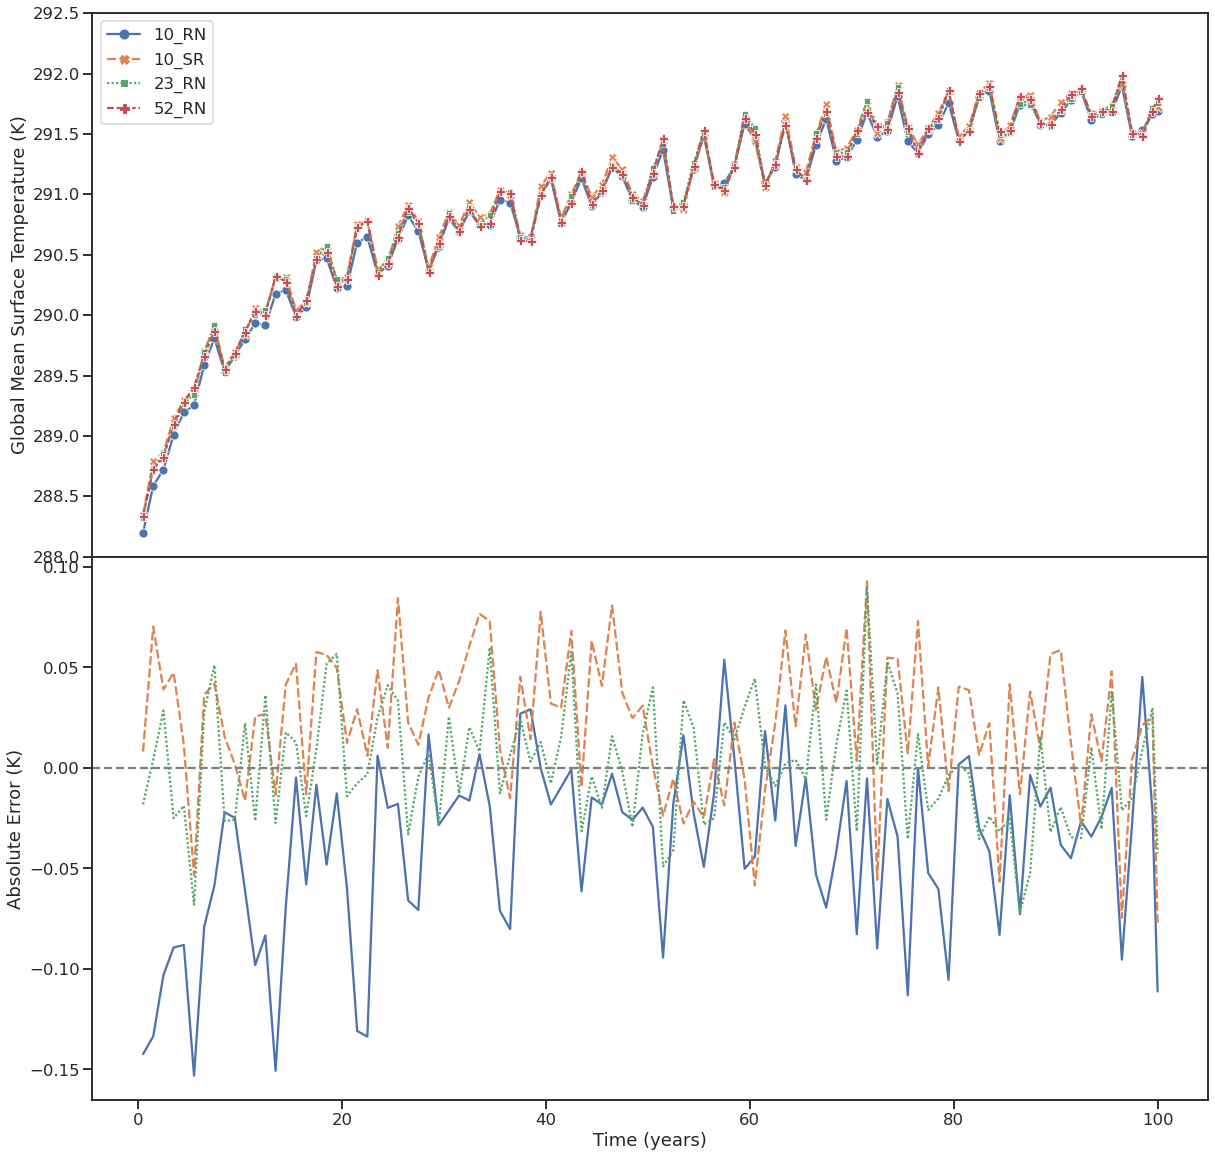

In [82]:
plot_timeseries(df,time_period=365)

Average:


,temperature,X,years,merge_column,Xtruth,temperaturetruth,MBE,MAE
precision,,,,,,,,
10_RN,290.901433,18250.0,50.0,18250.0,18250.0,290.940274,-0.038841,0.126078
10_SR,290.963730,18250.0,50.0,18250.0,18250.0,290.940274,0.023456,0.135560
23_RN,290.941337,18250.0,50.0,18250.0,18250.0,290.940274,0.001063,0.120855


109503

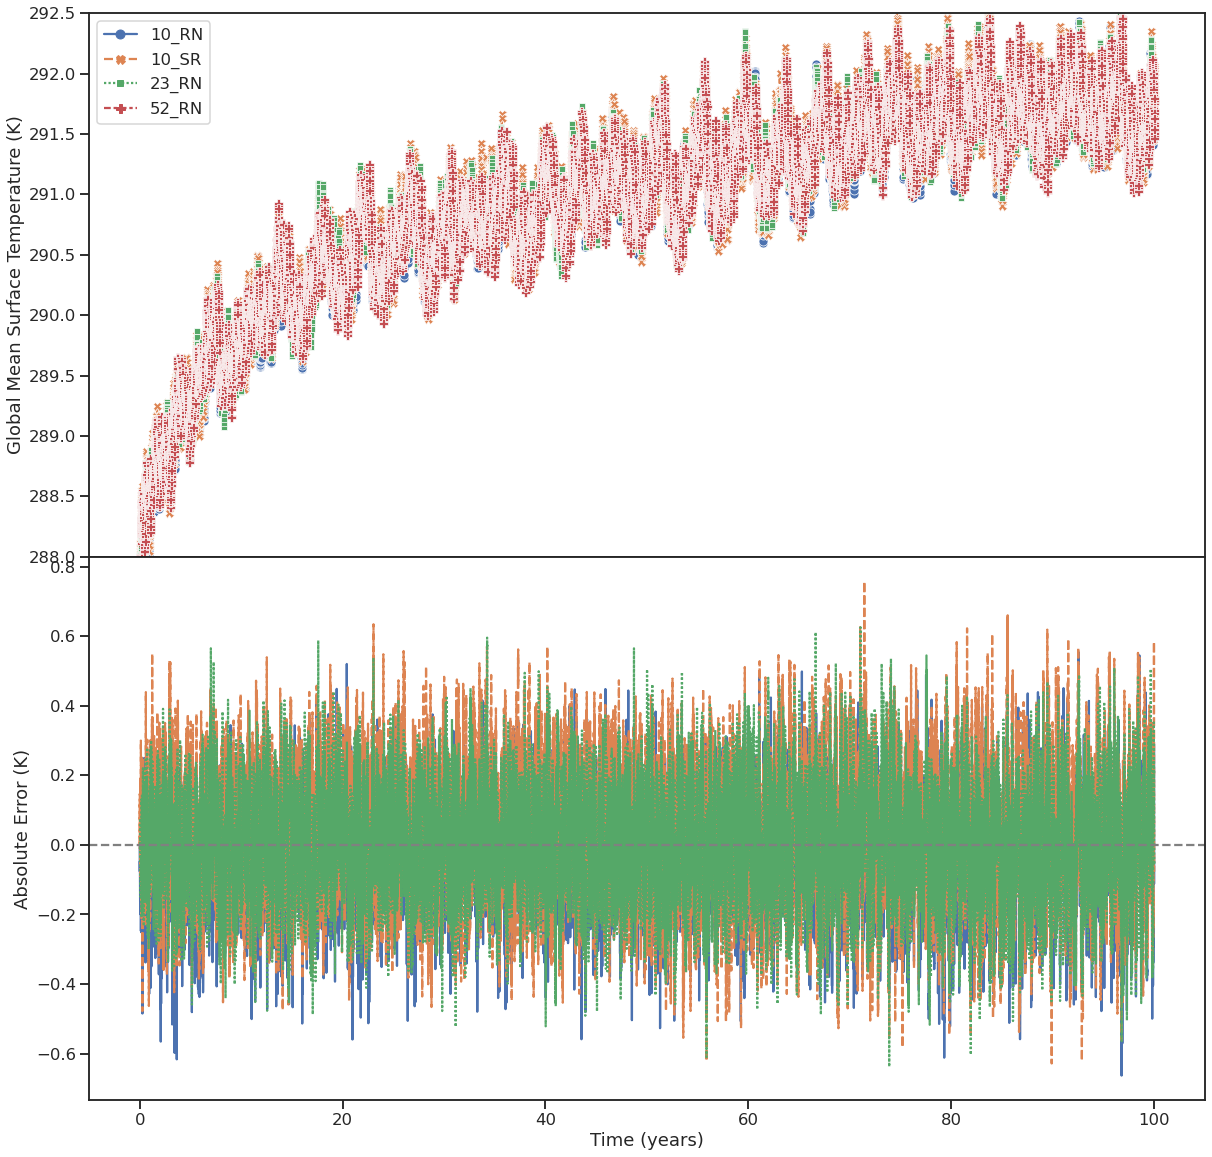

In [81]:
plot_timeseries(df,time_period=365)

In [44]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_config(ax1,ax2,save):
    

    #Config
    plt.subplots_adjust(wspace=0.1, hspace=0)

    ax1.set_ylabel("Gloabl Mean Surface Temperature (K)")#, fontsize = 20)
    ax2.set_ylabel("Absolute Error (K)")#, fontsize = 20)


    ax2.set_xlabel("Time (years)")#, fontsize = 20)
    ax2.axhline(0.0, c='0.5', linestyle='--')
    

   # ax1.set_xlim(0,400)
    ax1.set_ylim(288,292.5)

    #Other config
    ax1.legend().set_title(None)
    
    if save:
        plt.savefig('figs/Fig1_Williams.png', dpi=300, bbox_inches='tight')


    
    
def get_relative_error_df(df):
    
    
    #Get a ground truth that all others will be compared against
    df_truth = df.query('precision == "52_RN" ')[['X', 'temperature']]
    df_truth['merge_column'] = df_truth['X'].astype(int)
    
    #Get the others
    df_rest = df.query('precision != "52_RN" ').reset_index(drop=True) #rest index to avoid SettingWithCopyWarning
    df_rest['merge_column'] = df_rest['X'].astype('int') 
    
    #Note integer conversions are needed for join

    #Rejoin - maybe a more efficient way to do this?
    df_join = pd.merge(df_rest,df_truth,how='left',on='merge_column', suffixes=(None, 'truth'))
    
    
    #Get the absolute error
    #df_join['error']  = df_join['temperature'] - df_join['temperaturetruth']
    df_join['error']  = abs(df_join['temperature'] - df_join['temperaturetruth'])/df_join['temperaturetruth']

    
    return df_join
    
def plot_error_timeseries(df1,df2,save_it):
    
    #Setup plot env
    h,w = 20,20

    sns.set_theme(context='talk', 
                  style='ticks', 
                  palette='deep',
                  rc={'figure.figsize':(h,w)}
                  )

    

    
    fig, (ax1,ax2) = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(h,w))
    
    df1['years'] = df1.X/365
    
    
    #Plot the df directly
    p = sns.lineplot(data=df1, x="years", y='temperature', hue="precision",ax=ax1,style='precision',markers=True)


    #Calculate the relative_error df and plot
    df_error = get_relative_error_df(df1)
    #df_error['years'] = df2.X #/365

    df_error['years'] = df_error['X']/365
    
    decadal_window = 1 #take an average over N years
    df_error_decadal = df_error.groupby([df_error.years//decadal_window, 'label','level','precision', 'title'],as_index=False).mean()
    p = sns.lineplot(data=df_error_decadal, x="years", y='error', hue="precision",ax=ax2,style='precision',markers=True,legend=None)


    plot_config(ax1,ax2,save_it)

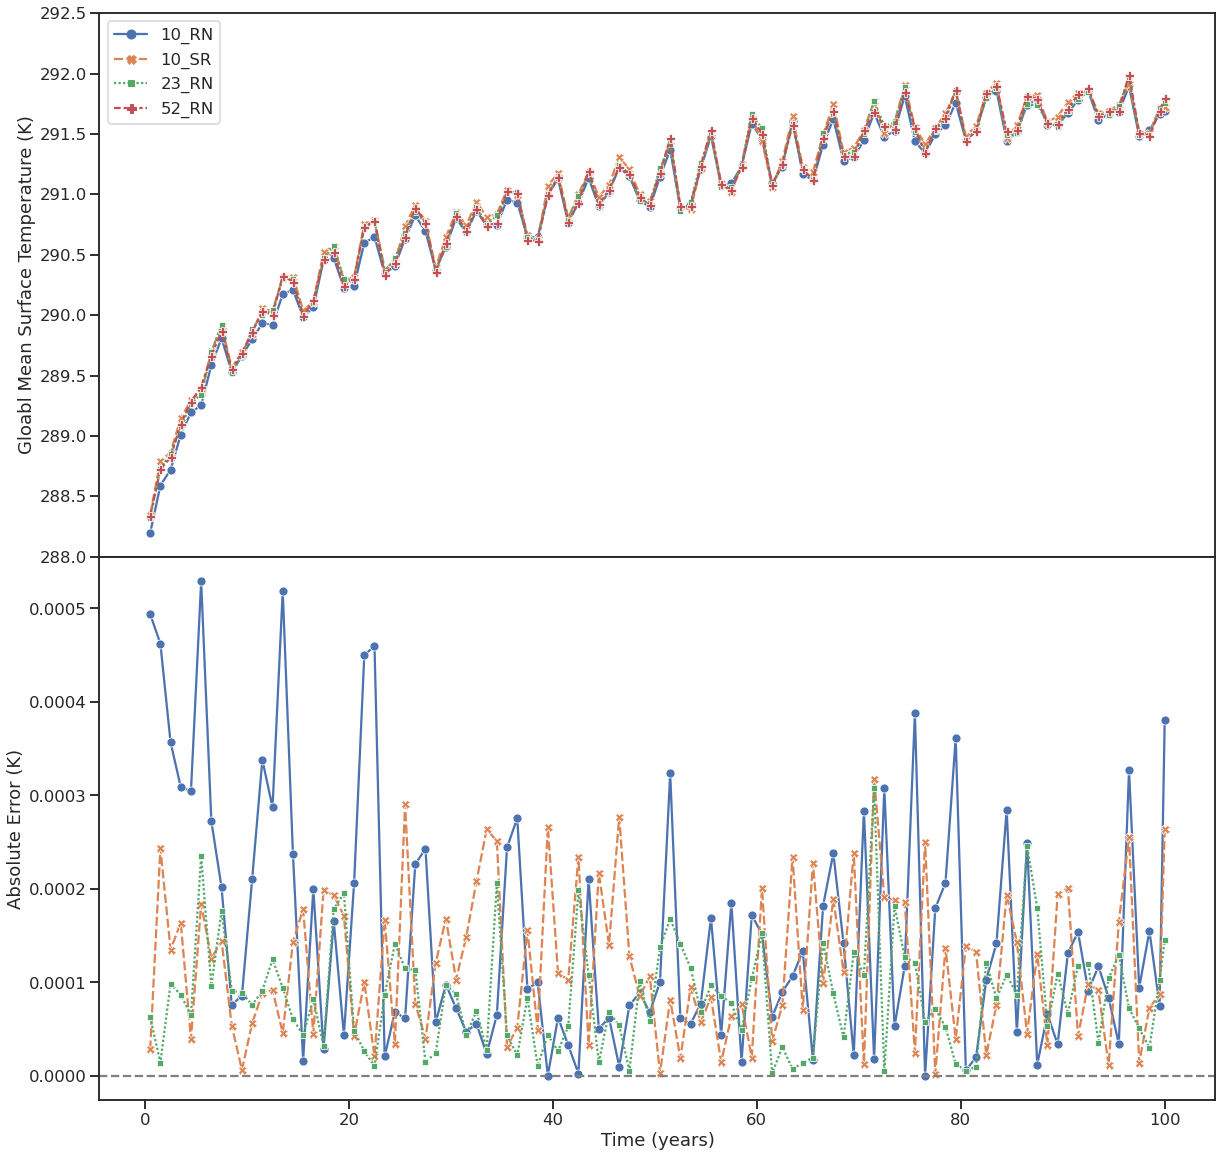

In [19]:
save_it = True #Do you want to save the Fig?
plot_error_timeseries(df_annual_mean,df_decadal_mean,save_it)

In [23]:
df_decadal_mean['years'] = df_decadal_mean.X/365 

In [21]:
df_error = get_relative_error_df(df_annual_mean)
